In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import warnings

In [17]:
warnings.filterwarnings('ignore')

# You'll need to install these libraries:
# pip install opencv-python deepface face_recognition pandas matplotlib seaborn tqdm sklearn

# Define paths
LABEL_PATH = r"C:\Users\jonat\Desktop\dataethicsproj\data259-project\analysis\data\fairface_label_train.csv"
IMAGE_PATH = r"C:\Users\jonat\Desktop\dataethicsproj\data259-project\analysis\data\fairface-img-margin025-trainval"
RESULTS_PATH = "results"
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

In [18]:
def load_fairface_data(split='train'):
    """
    Load FairFace dataset metadata.
    Args:
        split: 'train', 'val', or 'test' - currently only 'train' is supported based on provided paths
    Returns:
        DataFrame with image paths and annotations
    """
    if split != 'train':
        print(f"Warning: Only 'train' split is currently supported with the provided paths. Using 'train' instead of '{split}'.")
        split = 'train'
        
    csv_path = LABEL_PATH
    df = pd.read_csv(csv_path)
    
    # Add full image path - handle potential path issues
    df['image_path'] = df['file'].apply(lambda x: os.path.join(IMAGE_PATH, x))
    
    # Verify a few paths to make sure they exist
    sample_paths = df['image_path'].head(5).tolist()
    print("Checking sample image paths:")
    for path in sample_paths:
        exists = os.path.exists(path)
        print(f"  {path}: {'Exists' if exists else 'Does NOT exist'}")
        
    # If we need to fix the image paths, we can uncomment and modify the line below:
    # df['image_path'] = df['file'].apply(lambda x: os.path.join(IMAGE_PATH, os.path.basename(x)))
    
    # Ensure race categories are consistent
    race_categories = ['White', 'Black', 'East Asian', 'Southeast Asian', 
                       'Indian', 'Middle Eastern', 'Latino_Hispanic']
    
    # Verify that the race column exists and has the expected categories
    if 'race' not in df.columns:
        raise ValueError("The 'race' column is missing from the dataset")
    
    return df

In [19]:
def analyze_opencv_haar(data_df, sample_size=None):
    """
    Analyze OpenCV Haar Cascades face detection across racial groups.
    Args:
        data_df: DataFrame with image paths and race labels
        sample_size: Number of images to sample (for faster testing)
    Returns:
        DataFrame with detection results
    """
    print("Analyzing OpenCV Haar Cascades...")
    
    # Sample data if requested
    if sample_size and sample_size < len(data_df):
        data_df = data_df.sample(sample_size, random_state=42)
    
    # Load the pre-trained model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    results = []
    
    for idx, row in tqdm(data_df.iterrows(), total=len(data_df)):
        img_path = row['image_path']
        race = row['race']
        
        try:
            # Read image
            img = cv2.imread(img_path)
            if img is None:
                results.append({
                    'image_path': img_path,
                    'race': race,
                    'detected': False,
                    'confidence': 0,
                    'error': 'Image could not be loaded'
                })
                continue
                
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Detect faces with confidence scores
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, 
                                                 minNeighbors=5, minSize=(30, 30),
                                                 flags=cv2.CASCADE_SCALE_IMAGE)
            
            # Check if any faces were detected
            if len(faces) > 0:
                # OpenCV doesn't provide confidence scores directly, so we'll use
                # the number of neighbors as a proxy for confidence
                max_neighbors = 0
                for (x, y, w, h) in faces:
                    # Detect with different minNeighbors to get a "confidence" score
                    for neighbors in range(1, 10):
                        test_faces = face_cascade.detectMultiScale(
                            gray[y:y+h, x:x+w], 
                            scaleFactor=1.1, 
                            minNeighbors=neighbors
                        )
                        if len(test_faces) > 0:
                            max_neighbors = max(max_neighbors, neighbors)
                
                results.append({
                    'image_path': img_path,
                    'race': race,
                    'detected': True,
                    'confidence': max_neighbors / 10.0,  # Normalize to 0-1 range
                    'faces_count': len(faces),
                    'error': None
                })
            else:
                results.append({
                    'image_path': img_path,
                    'race': race,
                    'detected': False,
                    'confidence': 0,
                    'faces_count': 0,
                    'error': None
                })
                
        except Exception as e:
            results.append({
                'image_path': img_path,
                'race': race,
                'detected': False,
                'confidence': 0,
                'error': str(e)
            })
    
    results_df = pd.DataFrame(results)
    
    # Save results
    results_df.to_csv(os.path.join(RESULTS_PATH, 'opencv_haar_results.csv'), index=False)
    
    return results_df

In [20]:
def analyze_deepface(data_df, sample_size=None):
    """
    Analyze DeepFace for race classification and verification across racial groups.
    Args:
        data_df: DataFrame with image paths and race labels
        sample_size: Number of images to sample (for faster testing)
    Returns:
        Dictionary with race classification and verification results
    """
    print("Analyzing DeepFace...")
    
    # Import DeepFace here to avoid conflicts with other libraries
    from deepface import DeepFace
    
    # Sample data if requested
    if sample_size and sample_size < len(data_df):
        data_df = data_df.sample(sample_size, random_state=42)
    
    race_classification_results = []
    verification_results = {}
    
    # Create pairs for verification testing
    race_groups = data_df.groupby('race')
    pairs_by_race = {}
    
    # For each race, create pairs of the same person from different images
    # This is a simplified approach - in a real project, you'd need actual pairs of the same person
    # Here we're just simulating with random pairs within each race
    for race, group in race_groups:
        pairs_by_race[race] = []
        if len(group) >= 2:
            # Create random pairs - in a real project, you would use actual pairs of the same person
            # This is just for illustration
            random_pairs = group.sample(min(50, len(group) // 2) * 2, random_state=42).values
            for i in range(0, len(random_pairs), 2):
                if i+1 < len(random_pairs):
                    pairs_by_race[race].append((random_pairs[i][data_df.columns.get_loc('image_path')], 
                                              random_pairs[i+1][data_df.columns.get_loc('image_path')]))
    
    # Race classification analysis
    for idx, row in tqdm(data_df.iterrows(), total=len(data_df)):
        img_path = row['image_path']
        actual_race = row['race']
        
        try:
            # Analyze with DeepFace
            analysis = DeepFace.analyze(img_path=img_path, 
                                       actions=['race'],
                                       enforce_detection=False,
                                       silent=True)
            
            # DeepFace returns a list for batch processing
            if isinstance(analysis, list):
                analysis = analysis[0]
            
            # Get the predicted race and confidence
            predicted_race = max(analysis['race'].items(), key=lambda x: x[1])[0]
            confidence = max(analysis['race'].values())
            
            # Map DeepFace race categories to FairFace categories
            # This is a simplification - you'd need a more detailed mapping
            race_mapping = {
                'asian': 'East Asian',
                'indian': 'Indian',
                'black': 'Black',
                'white': 'White',
                'middle eastern': 'Middle Eastern',
                'latino hispanic': 'Latino_Hispanic'
            }
            
            mapped_race = race_mapping.get(predicted_race.lower(), predicted_race)
            
            race_classification_results.append({
                'image_path': img_path,
                'actual_race': actual_race,
                'predicted_race': mapped_race,
                'confidence': confidence,
                'correct': mapped_race == actual_race,
                'error': None
            })
            
        except Exception as e:
            race_classification_results.append({
                'image_path': img_path,
                'actual_race': actual_race,
                'predicted_race': None,
                'confidence': 0,
                'correct': False,
                'error': str(e)
            })
    
    # Verification analysis
    for race, pairs in pairs_by_race.items():
        verification_results[race] = []
        
        for img1_path, img2_path in tqdm(pairs, desc=f"Verification for {race}"):
            try:
                # Verify with DeepFace
                result = DeepFace.verify(img1_path=img1_path,
                                        img2_path=img2_path,
                                        enforce_detection=False,
                                        silent=True)
                
                verification_results[race].append({
                    'img1_path': img1_path,
                    'img2_path': img2_path,
                    'verified': result['verified'],
                    'distance': result['distance'],
                    'threshold': result['threshold'],
                    'model': result['model'],
                    'error': None
                })
                
            except Exception as e:
                verification_results[race].append({
                    'img1_path': img1_path,
                    'img2_path': img2_path,
                    'verified': False,
                    'distance': None,
                    'threshold': None,
                    'model': None,
                    'error': str(e)
                })
    
    # Save results
    race_classification_df = pd.DataFrame(race_classification_results)
    race_classification_df.to_csv(os.path.join(RESULTS_PATH, 'deepface_race_classification.csv'), index=False)
    
    for race, results in verification_results.items():
        verification_df = pd.DataFrame(results)
        verification_df.to_csv(os.path.join(RESULTS_PATH, f'deepface_verification_{race}.csv'), index=False)
    
    return {
        'race_classification': race_classification_df,
        'verification': verification_results
    }

In [21]:
def analyze_face_recognition(data_df, sample_size=None):
    """
    Analyze face_recognition library across racial groups.
    Args:
        data_df: DataFrame with image paths and race labels
        sample_size: Number of images to sample (for faster testing)
    Returns:
        DataFrame with face encoding results and a dictionary with face matching results
    """
    print("Analyzing face_recognition library...")
    
    import face_recognition
    
    # Sample data if requested
    if sample_size and sample_size < len(data_df):
        data_df = data_df.sample(sample_size, random_state=42)
    
    encoding_results = []
    
    # Face encoding analysis
    for idx, row in tqdm(data_df.iterrows(), total=len(data_df)):
        img_path = row['image_path']
        race = row['race']
        
        try:
            # Load image
            image = face_recognition.load_image_file(img_path)
            
            # Find face locations
            face_locations = face_recognition.face_locations(image)
            
            if len(face_locations) > 0:
                # Get face encodings
                face_encodings = face_recognition.face_encodings(image, face_locations)
                
                encoding_results.append({
                    'image_path': img_path,
                    'race': race,
                    'detected': True,
                    'faces_count': len(face_locations),
                    'has_encoding': len(face_encodings) > 0,
                    'error': None
                })
            else:
                encoding_results.append({
                    'image_path': img_path,
                    'race': race,
                    'detected': False,
                    'faces_count': 0,
                    'has_encoding': False,
                    'error': 'No faces detected'
                })
                
        except Exception as e:
            encoding_results.append({
                'image_path': img_path,
                'race': race,
                'detected': False,
                'faces_count': 0,
                'has_encoding': False,
                'error': str(e)
            })
    
    encoding_df = pd.DataFrame(encoding_results)
    
    # Create face matching test
    # Group by race
    race_groups = data_df.groupby('race')
    matching_results = {}
    
    # For each race, test face matching accuracy
    for race, group in race_groups:
        # Filter successful encodings for this race
        successful_encodings = encoding_df[
            (encoding_df['race'] == race) & 
            (encoding_df['has_encoding'] == True)
        ]
        
        if len(successful_encodings) < 10:
            print(f"Not enough successful encodings for {race}, skipping matching test")
            continue
        
        # Sample images to test
        test_images = successful_encodings.sample(min(30, len(successful_encodings)), random_state=42)
        
        same_person_pairs = []
        different_person_pairs = []
        
        # In a real project, you would use actual pairs of the same person
        # This is a simplified approach for demonstration
        
        # Create pairs of different people (different images)
        if len(test_images) >= 2:
            for i in range(min(50, len(test_images))):
                # Select two random images
                pair = test_images.sample(2, random_state=i).values
                img1_path = pair[0][test_images.columns.get_loc('image_path')]
                img2_path = pair[1][test_images.columns.get_loc('image_path')]
                
                # In a real project, you would check if these are the same person
                # For this demo, we'll assume different images are different people
                different_person_pairs.append((img1_path, img2_path, False))
        
        # For same person pairs, in a real project you would use multiple images of the same person
        # Since we don't have that information, we'll create synthetic "same person" pairs
        # by slightly modifying images (this is just for demonstration)
        for idx, row in test_images.iterrows():
            img_path = row['image_path']
            
            try:
                # Load the image
                image = face_recognition.load_image_file(img_path)
                
                # Create a slightly modified version (brightness adjustment)
                modified_image = np.clip(image * 1.1, 0, 255).astype(np.uint8)
                
                # Save the modified image
                modified_path = os.path.join(RESULTS_PATH, f"modified_{os.path.basename(img_path)}")
                cv2.imwrite(modified_path, cv2.cvtColor(modified_image, cv2.COLOR_RGB2BGR))
                
                # Add as a "same person" pair
                same_person_pairs.append((img_path, modified_path, True))
                
            except Exception as e:
                print(f"Error creating modified image for {img_path}: {e}")
        
        # Combine all pairs
        all_pairs = same_person_pairs + different_person_pairs
        
        # Test matching accuracy
        matching_results[race] = []
        
        for img1_path, img2_path, same_person in tqdm(all_pairs, desc=f"Matching test for {race}"):
            try:
                # Load images
                img1 = face_recognition.load_image_file(img1_path)
                img2 = face_recognition.load_image_file(img2_path)
                
                # Get face encodings
                img1_encoding = face_recognition.face_encodings(img1)[0]
                img2_encoding = face_recognition.face_encodings(img2)[0]
                
                # Compare faces
                # Test with different tolerance thresholds
                thresholds = [0.4, 0.5, 0.6, 0.7]
                threshold_results = {}
                
                for threshold in thresholds:
                    # Calculate distance
                    face_distance = face_recognition.face_distance([img1_encoding], img2_encoding)[0]
                    matches = face_distance <= threshold
                    
                    threshold_results[threshold] = {
                        'distance': face_distance,
                        'matches': matches,
                        'correct': matches == same_person
                    }
                
                matching_results[race].append({
                    'img1_path': img1_path,
                    'img2_path': img2_path,
                    'actual_same_person': same_person,
                    'face_distance': face_distance,
                    'thresholds': threshold_results,
                    'error': None
                })
                
            except Exception as e:
                matching_results[race].append({
                    'img1_path': img1_path,
                    'img2_path': img2_path,
                    'actual_same_person': same_person,
                    'face_distance': None,
                    'thresholds': None,
                    'error': str(e)
                })
    
    # Save results
    encoding_df.to_csv(os.path.join(RESULTS_PATH, 'face_recognition_encoding.csv'), index=False)
    
    for race, results in matching_results.items():
        if results:  # Only save if there are results
            matching_df = pd.DataFrame([
                {
                    'img1_path': r['img1_path'],
                    'img2_path': r['img2_path'],
                    'actual_same_person': r['actual_same_person'],
                    'face_distance': r['face_distance'],
                    'error': r['error']
                }
                for r in results if 'img1_path' in r
            ])
            
            matching_df.to_csv(os.path.join(RESULTS_PATH, f'face_recognition_matching_{race}.csv'), index=False)
    
    return {
        'encoding': encoding_df,
        'matching': matching_results
    }   

In [22]:
def analyze_opencv_results(results_df):
    """
    Analyze OpenCV Haar Cascades results.
    Args:
        results_df: DataFrame with detection results
    """
    print("\n--- OpenCV Haar Cascades Analysis ---")
    
    # Detection rate by race
    detection_by_race = results_df.groupby('race')['detected'].mean()
    print("\nDetection Rate by Race:")
    print(detection_by_race)
    
    # Average confidence by race (for detected faces)
    confidence_by_race = results_df[results_df['detected']].groupby('race')['confidence'].mean()
    print("\nAverage Confidence by Race (for detected faces):")
    print(confidence_by_race)
    
    # Plot detection rate by race
    plt.figure(figsize=(12, 6))
    sns.barplot(x=detection_by_race.index, y=detection_by_race.values)
    plt.title('Face Detection Rate by Race (OpenCV Haar Cascades)')
    plt.xlabel('Race')
    plt.ylabel('Detection Rate')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'opencv_detection_rate.png'))
    
    # Plot confidence by race
    plt.figure(figsize=(12, 6))
    sns.barplot(x=confidence_by_race.index, y=confidence_by_race.values)
    plt.title('Average Confidence by Race (OpenCV Haar Cascades)')
    plt.xlabel('Race')
    plt.ylabel('Confidence Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'opencv_confidence.png'))

In [23]:
def analyze_deepface_results(results):
    """
    Analyze DeepFace results.
    Args:
        results: Dictionary with race classification and verification results
    """
    race_classification_df = results['race_classification']
    verification_results = results['verification']
    
    print("\n--- DeepFace Analysis ---")
    
    # Race classification accuracy
    race_accuracy = race_classification_df.groupby('actual_race')['correct'].mean()
    print("\nRace Classification Accuracy by Race:")
    print(race_accuracy)
    
    # Average confidence by race
    confidence_by_race = race_classification_df.groupby('actual_race')['confidence'].mean()
    print("\nAverage Confidence by Race:")
    print(confidence_by_race)
    
    # Confusion matrix for race classification
    actual_races = race_classification_df['actual_race'].values
    predicted_races = race_classification_df['predicted_race'].values
    
    # Filter out None values
    valid_indices = [i for i, x in enumerate(predicted_races) if x is not None]
    actual_races = [actual_races[i] for i in valid_indices]
    predicted_races = [predicted_races[i] for i in valid_indices]
    
    if actual_races and predicted_races:
        race_labels = sorted(list(set(actual_races) | set(predicted_races)))
        conf_matrix = confusion_matrix(actual_races, predicted_races, labels=race_labels)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=race_labels, yticklabels=race_labels)
        plt.title('Race Classification Confusion Matrix (DeepFace)')
        plt.xlabel('Predicted Race')
        plt.ylabel('Actual Race')
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_PATH, 'deepface_confusion_matrix.png'))
    
    # Plot race classification accuracy
    plt.figure(figsize=(12, 6))
    sns.barplot(x=race_accuracy.index, y=race_accuracy.values)
    plt.title('Race Classification Accuracy by Race (DeepFace)')
    plt.xlabel('Race')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'deepface_race_accuracy.png'))
    
    # Verification analysis
    verification_summary = {}
    
    for race, results in verification_results.items():
        if not results:
            continue
            
        # Convert to DataFrame for easier analysis
        results_df = pd.DataFrame([r for r in results if 'verified' in r and r['distance'] is not None])
        
        if len(results_df) == 0:
            continue
            
        # Calculate verification metrics
        verification_summary[race] = {
            'avg_distance': results_df['distance'].mean(),
            'verification_rate': results_df['verified'].mean(),
            'sample_size': len(results_df)
        }
    
    if verification_summary:
        verification_df = pd.DataFrame(verification_summary).T
        print("\nVerification Results by Race:")
        print(verification_df)
        
        # Plot verification results
        plt.figure(figsize=(12, 6))
        sns.barplot(x=verification_df.index, y=verification_df['verification_rate'])
        plt.title('Face Verification Rate by Race (DeepFace)')
        plt.xlabel('Race')
        plt.ylabel('Verification Rate')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_PATH, 'deepface_verification_rate.png'))
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=verification_df.index, y=verification_df['avg_distance'])
        plt.title('Average Face Distance by Race (DeepFace)')
        plt.xlabel('Race')
        plt.ylabel('Average Distance')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_PATH, 'deepface_avg_distance.png'))

In [24]:
def analyze_face_recognition_results(results):
    """
    Analyze face_recognition library results.
    Args:
        results: Dictionary with encoding and matching results
    """
    encoding_df = results['encoding']
    matching_results = results['matching']
    
    print("\n--- face_recognition Analysis ---")
    
    # Detection rate by race
    detection_by_race = encoding_df.groupby('race')['detected'].mean()
    print("\nDetection Rate by Race:")
    print(detection_by_race)
    
    # Encoding success rate by race
    encoding_by_race = encoding_df.groupby('race')['has_encoding'].mean()
    print("\nEncoding Success Rate by Race:")
    print(encoding_by_race)
    
    # Plot detection rate by race
    plt.figure(figsize=(12, 6))
    sns.barplot(x=detection_by_race.index, y=detection_by_race.values)
    plt.title('Face Detection Rate by Race (face_recognition)')
    plt.xlabel('Race')
    plt.ylabel('Detection Rate')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'face_recognition_detection_rate.png'))
    
    # Matching analysis
    threshold_performance = {}
    
    for race, results in matching_results.items():
        if not results:
            continue
            
        # Analyze performance at different thresholds
        threshold_results = {}
        
        for threshold in [0.4, 0.5, 0.6, 0.7]:
            correct_matches = sum(
                1 for r in results 
                if 'thresholds' in r and r['thresholds'] is not None and 
                threshold in r['thresholds'] and 
                r['thresholds'][threshold]['correct']
            )
            
            total_valid = sum(
                1 for r in results 
                if 'thresholds' in r and r['thresholds'] is not None and 
                threshold in r['thresholds']
            )
            
            if total_valid > 0:
                accuracy = correct_matches / total_valid
            else:
                accuracy = 0
                
            threshold_results[threshold] = {
                'accuracy': accuracy,
                'sample_size': total_valid
            }
        
        threshold_performance[race] = threshold_results
    
    # Find the optimal threshold for each race
    optimal_thresholds = {}
    
    for race, thresholds in threshold_performance.items():
        best_accuracy = 0
        best_threshold = None
        
        for threshold, metrics in thresholds.items():
            if metrics['accuracy'] > best_accuracy:
                best_accuracy = metrics['accuracy']
                best_threshold = threshold
        
        optimal_thresholds[race] = {
            'threshold': best_threshold,
            'accuracy': best_accuracy
        }
    
    # Print optimal thresholds
    if optimal_thresholds:
        print("\nOptimal Thresholds by Race:")
        for race, metrics in optimal_thresholds.items():
            print(f"{race}: Threshold = {metrics['threshold']}, Accuracy = {metrics['accuracy']:.4f}")
        
        # Plot optimal thresholds
        plt.figure(figsize=(12, 6))
        races = list(optimal_thresholds.keys())
        thresholds = [optimal_thresholds[race]['threshold'] for race in races]
        
        sns.barplot(x=races, y=thresholds)
        plt.title('Optimal Face Matching Threshold by Race (face_recognition)')
        plt.xlabel('Race')
        plt.ylabel('Optimal Threshold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_PATH, 'face_recognition_optimal_thresholds.png'))
        
        # Plot accuracy at optimal threshold
        plt.figure(figsize=(12, 6))
        accuracies = [optimal_thresholds[race]['accuracy'] for race in races]
        
        sns.barplot(x=races, y=accuracies)
        plt.title('Matching Accuracy at Optimal Threshold by Race (face_recognition)')
        plt.xlabel('Race')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_PATH, 'face_recognition_optimal_accuracy.png'))

Checking sample image paths:
  C:\Users\jonat\Desktop\dataethicsproj\data259-project\analysis\data\fairface-img-margin025-trainval\train/1.jpg: Exists
  C:\Users\jonat\Desktop\dataethicsproj\data259-project\analysis\data\fairface-img-margin025-trainval\train/2.jpg: Exists
  C:\Users\jonat\Desktop\dataethicsproj\data259-project\analysis\data\fairface-img-margin025-trainval\train/3.jpg: Exists
  C:\Users\jonat\Desktop\dataethicsproj\data259-project\analysis\data\fairface-img-margin025-trainval\train/4.jpg: Exists
  C:\Users\jonat\Desktop\dataethicsproj\data259-project\analysis\data\fairface-img-margin025-trainval\train/5.jpg: Exists
Loaded 86744 images from FairFace dataset

Race distribution in dataset:
race
White              16527
Latino_Hispanic    13367
Indian             12319
East Asian         12287
Black              12233
Southeast Asian    10795
Middle Eastern      9216
Name: count, dtype: int64
Analyzing OpenCV Haar Cascades...


100%|██████████| 50/50 [00:04<00:00, 11.92it/s]



--- OpenCV Haar Cascades Analysis ---

Detection Rate by Race:
race
Black              0.285714
East Asian         0.666667
Indian             0.285714
Latino_Hispanic    0.636364
Middle Eastern     0.666667
Southeast Asian    0.666667
White              0.714286
Name: detected, dtype: float64

Average Confidence by Race (for detected faces):
race
Black              0.450000
East Asian         0.250000
Indian             0.550000
Latino_Hispanic    0.371429
Middle Eastern     0.325000
Southeast Asian    0.425000
White              0.640000
Name: confidence, dtype: float64
Analyzing DeepFace...


Verification for White: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]



--- DeepFace Analysis ---

Race Classification Accuracy by Race:
actual_race
Black              1.000000
East Asian         0.833333
Indian             0.285714
Latino_Hispanic    0.363636
Middle Eastern     0.666667
Southeast Asian    0.000000
White              0.714286
Name: correct, dtype: float64

Average Confidence by Race:
actual_race
Black              80.851078
East Asian         74.884427
Indian             57.048712
Latino_Hispanic    42.992426
Middle Eastern     61.596500
Southeast Asian    61.210301
White              56.720449
Name: confidence, dtype: float64

Verification Results by Race:
                 avg_distance  verification_rate  sample_size
Black                0.687314           0.333333          3.0
East Asian           0.749953           0.333333          3.0
Indian               0.822440           0.000000          3.0
Latino_Hispanic      0.777677           0.000000          5.0
Middle Eastern       0.872847           0.000000          3.0
Southeast Asian 

100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


Not enough successful encodings for Black, skipping matching test
Not enough successful encodings for East Asian, skipping matching test
Not enough successful encodings for Indian, skipping matching test


Matching test for Latino_Hispanic: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Not enough successful encodings for Middle Eastern, skipping matching test
Not enough successful encodings for Southeast Asian, skipping matching test
Not enough successful encodings for White, skipping matching test

--- face_recognition Analysis ---

Detection Rate by Race:
race
Black              0.571429
East Asian         0.666667
Indian             0.428571
Latino_Hispanic    0.909091
Middle Eastern     1.000000
Southeast Asian    0.833333
White              0.857143
Name: detected, dtype: float64

Encoding Success Rate by Race:
race
Black              0.571429
East Asian         0.666667
Indian             0.428571
Latino_Hispanic    0.909091
Middle Eastern     1.000000
Southeast Asian    0.833333
White              0.857143
Name: has_encoding, dtype: float64

Optimal Thresholds by Race:
Latino_Hispanic: Threshold = 0.4, Accuracy = 1.0000

--- Comparative Analysis ---

Detection Rate Comparison:
                   OpenCV  face_recognition  DeepFace
race                          

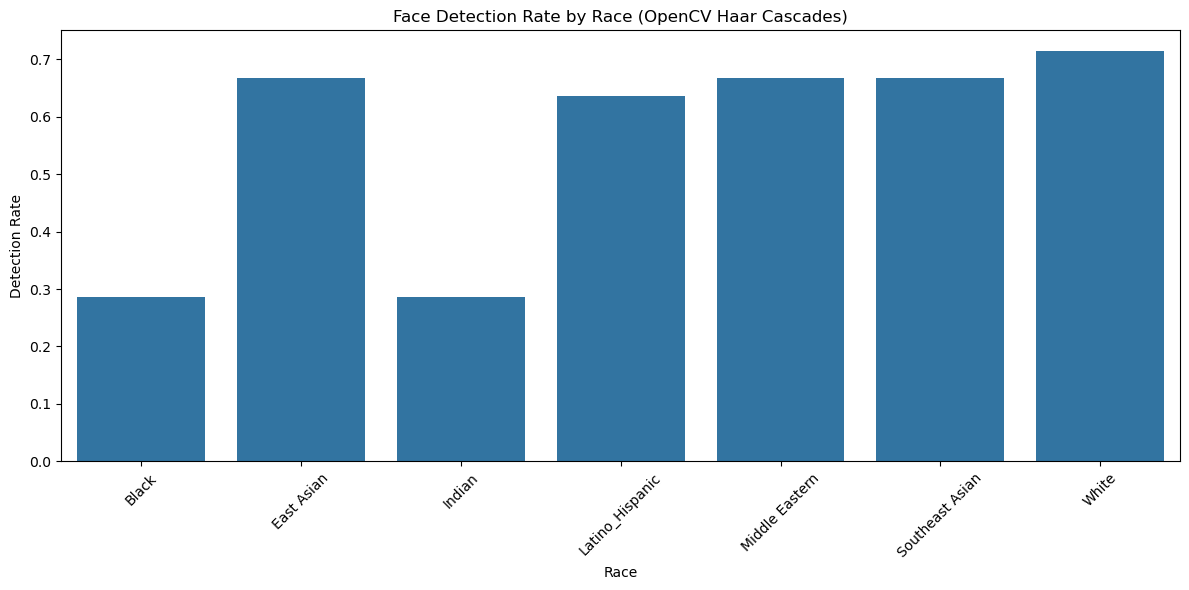

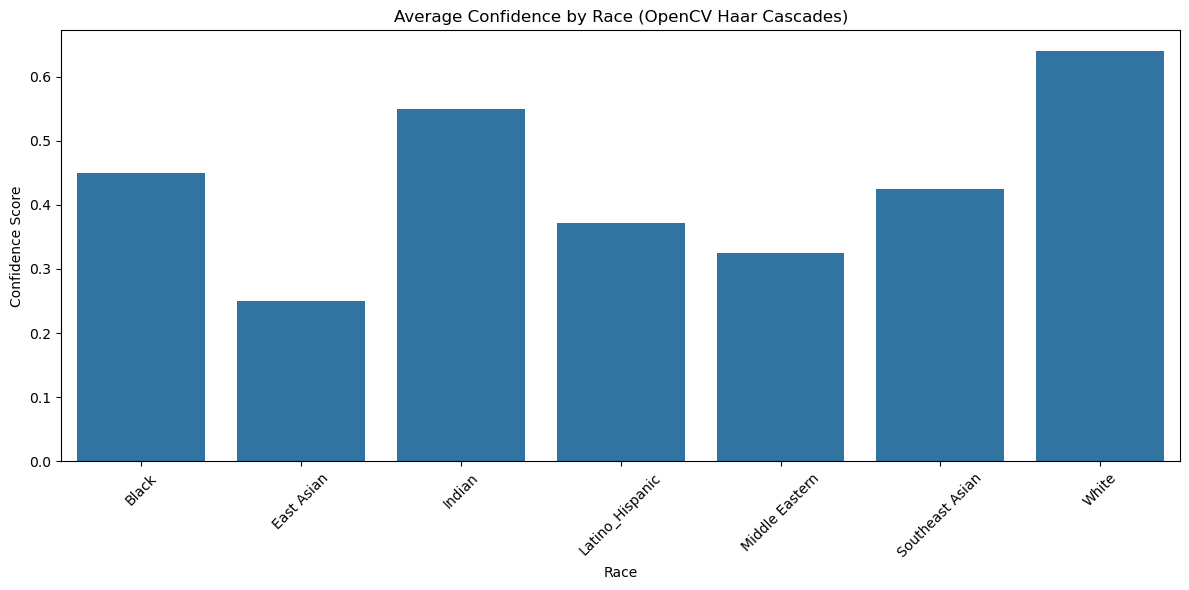

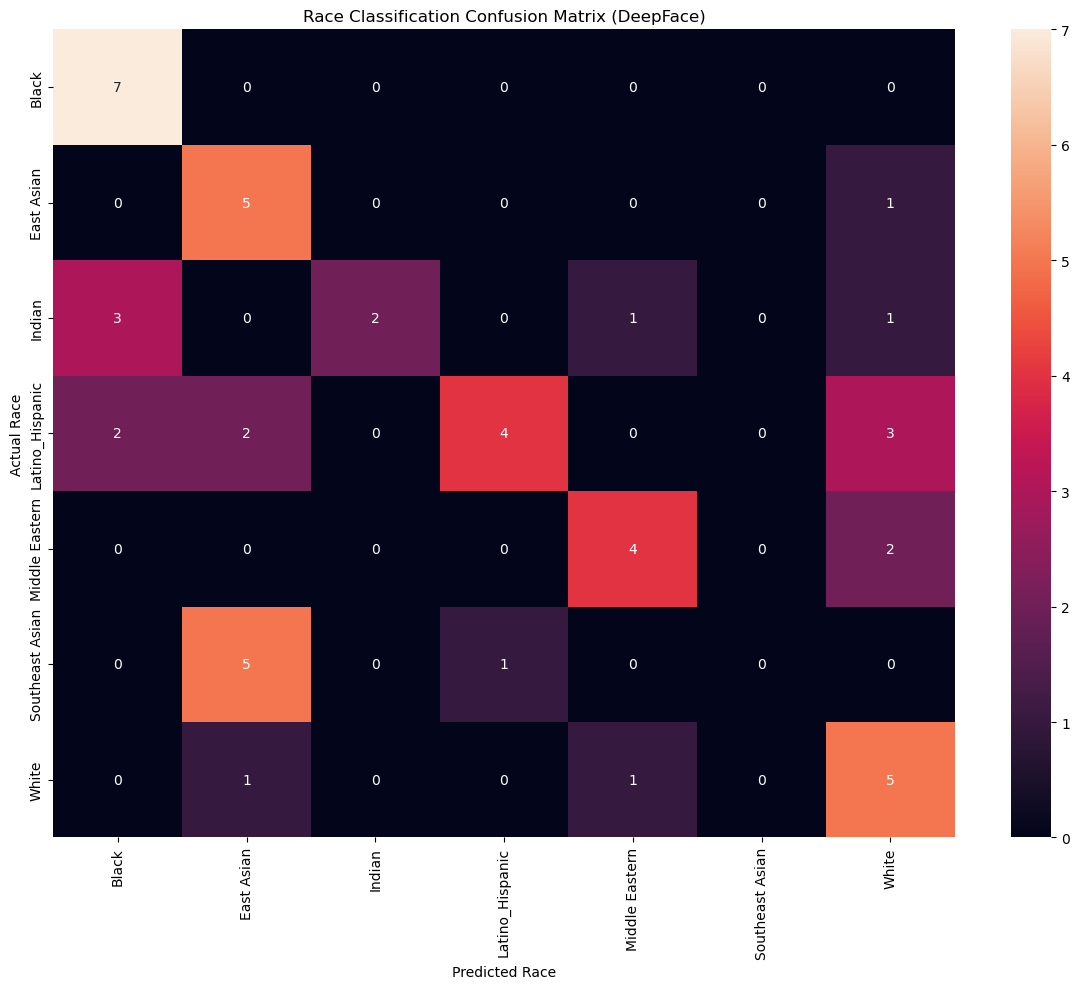

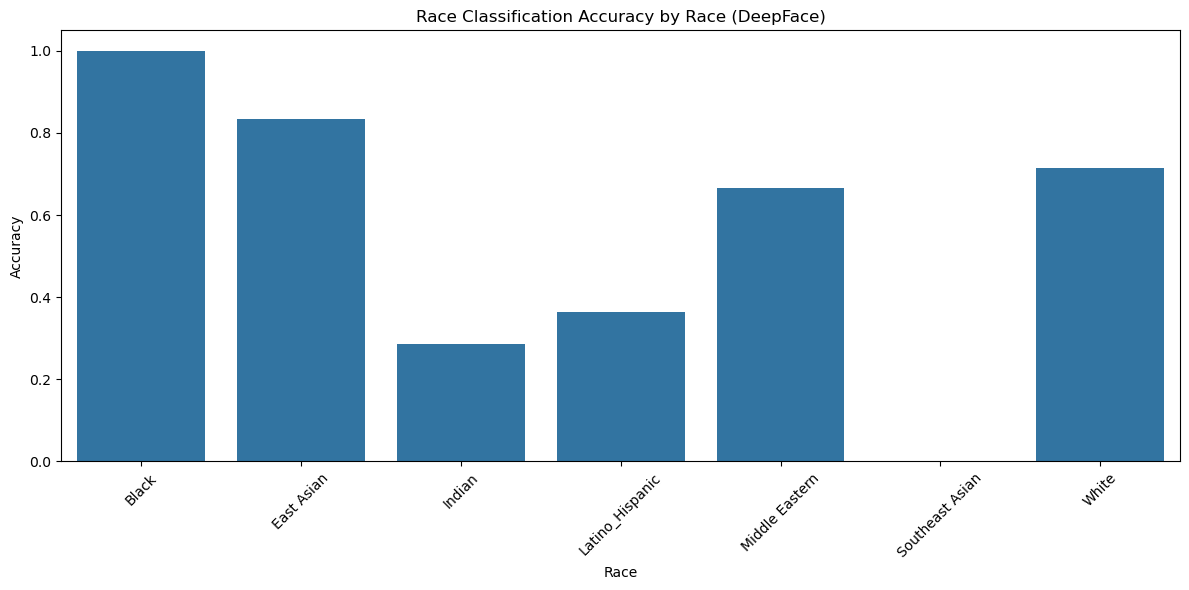

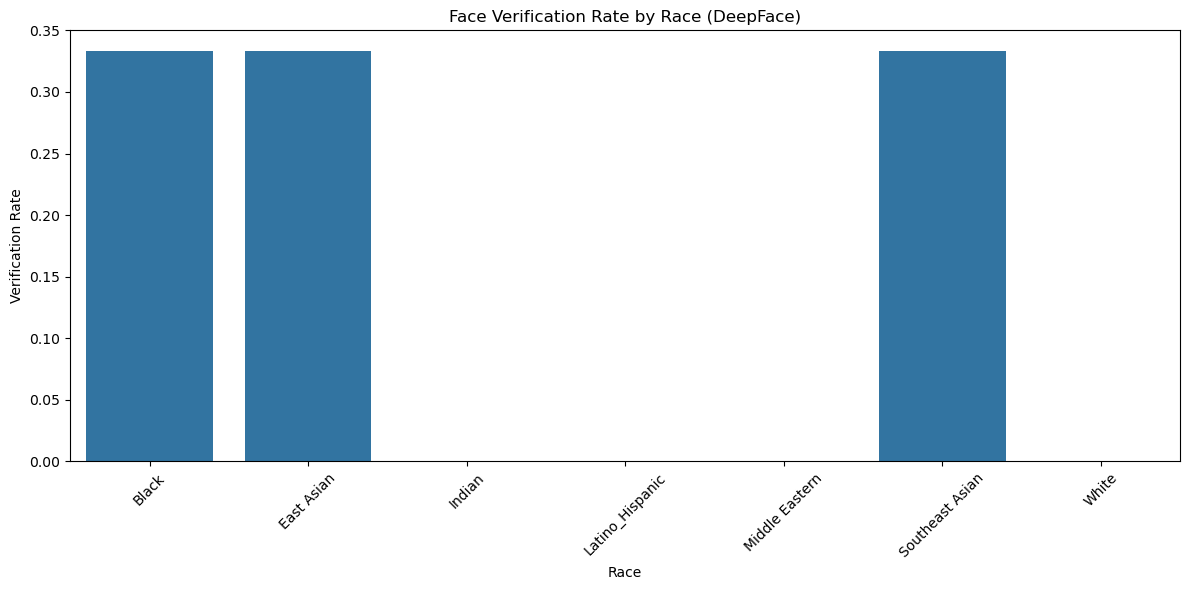

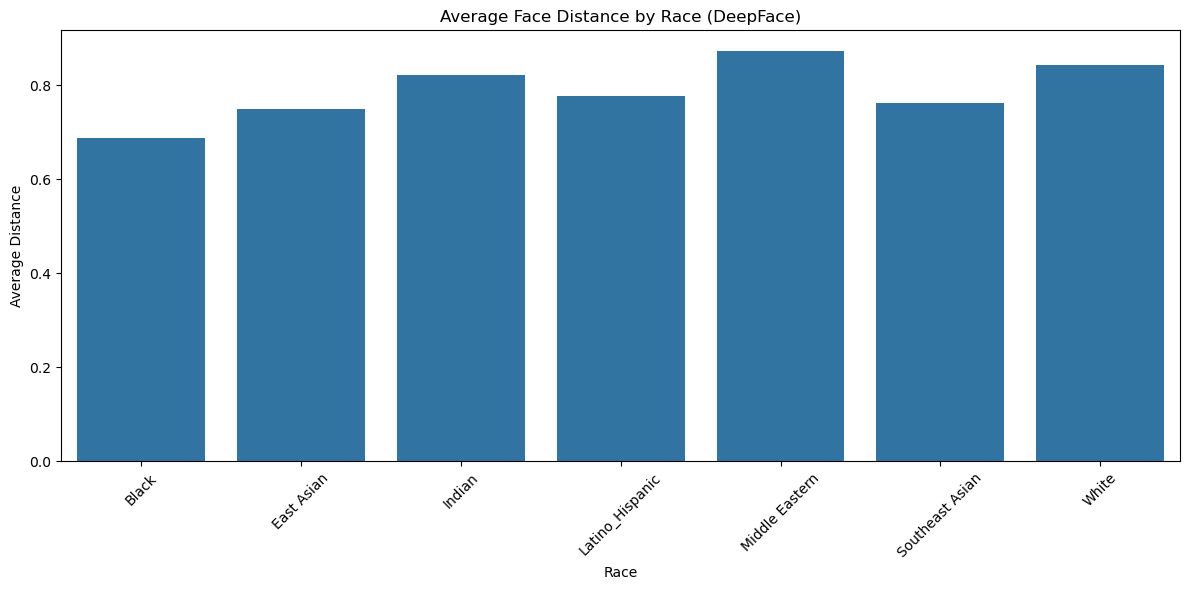

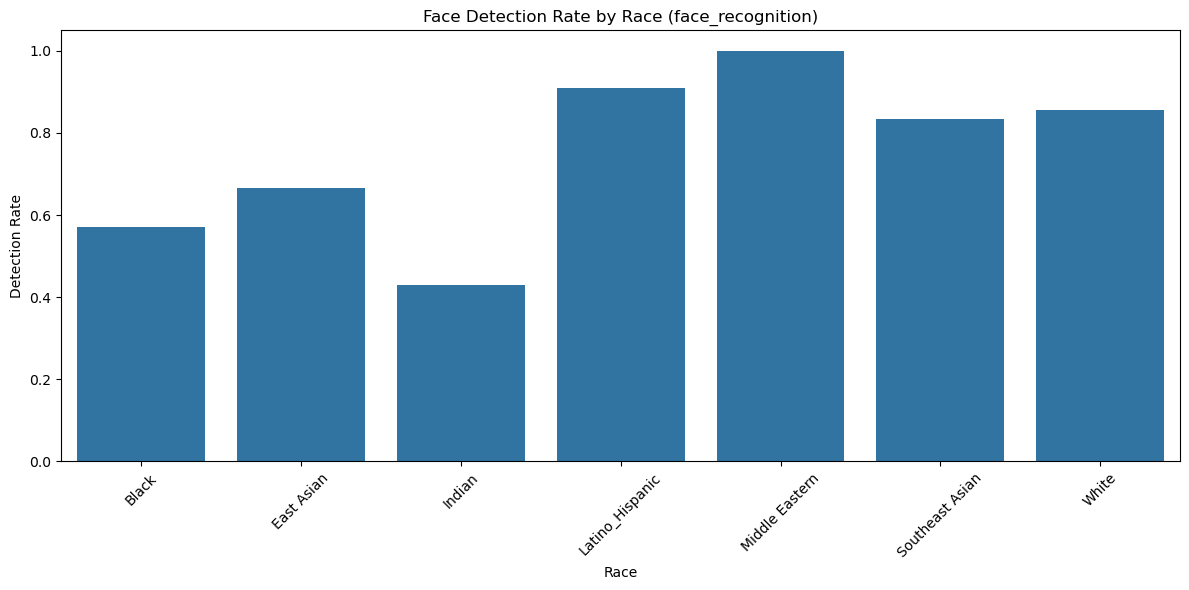

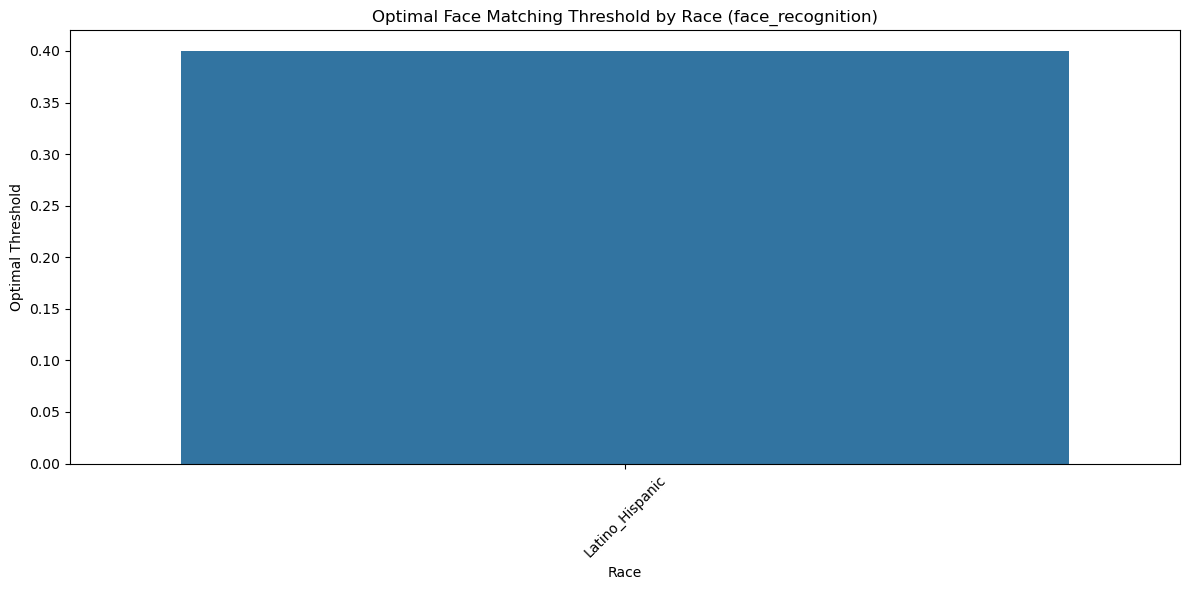

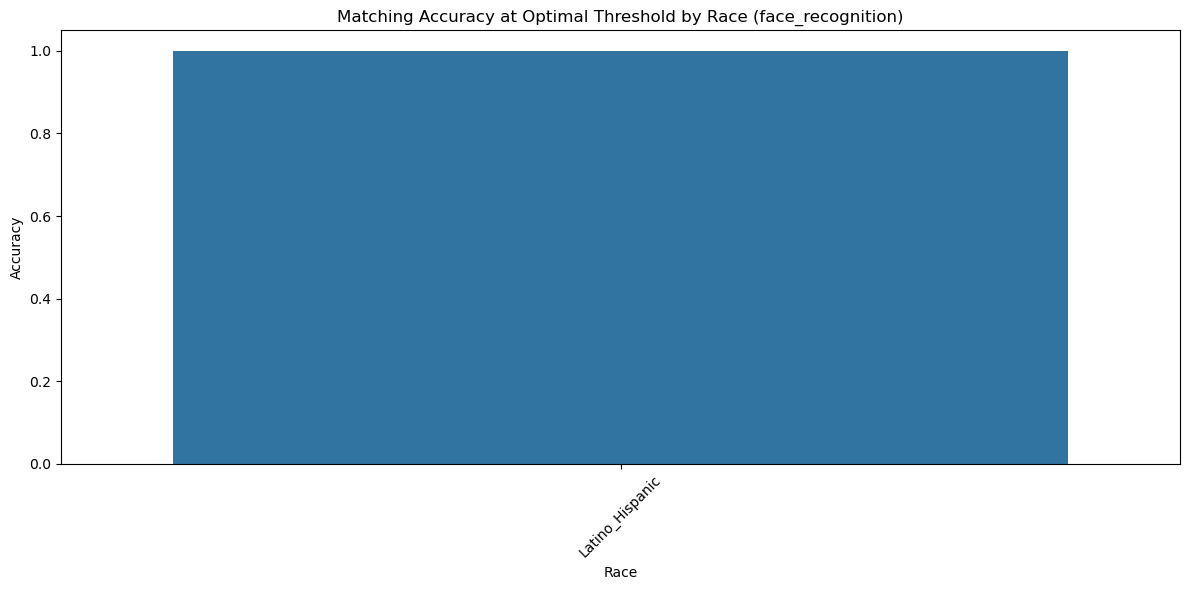

<Figure size 1400x800 with 0 Axes>

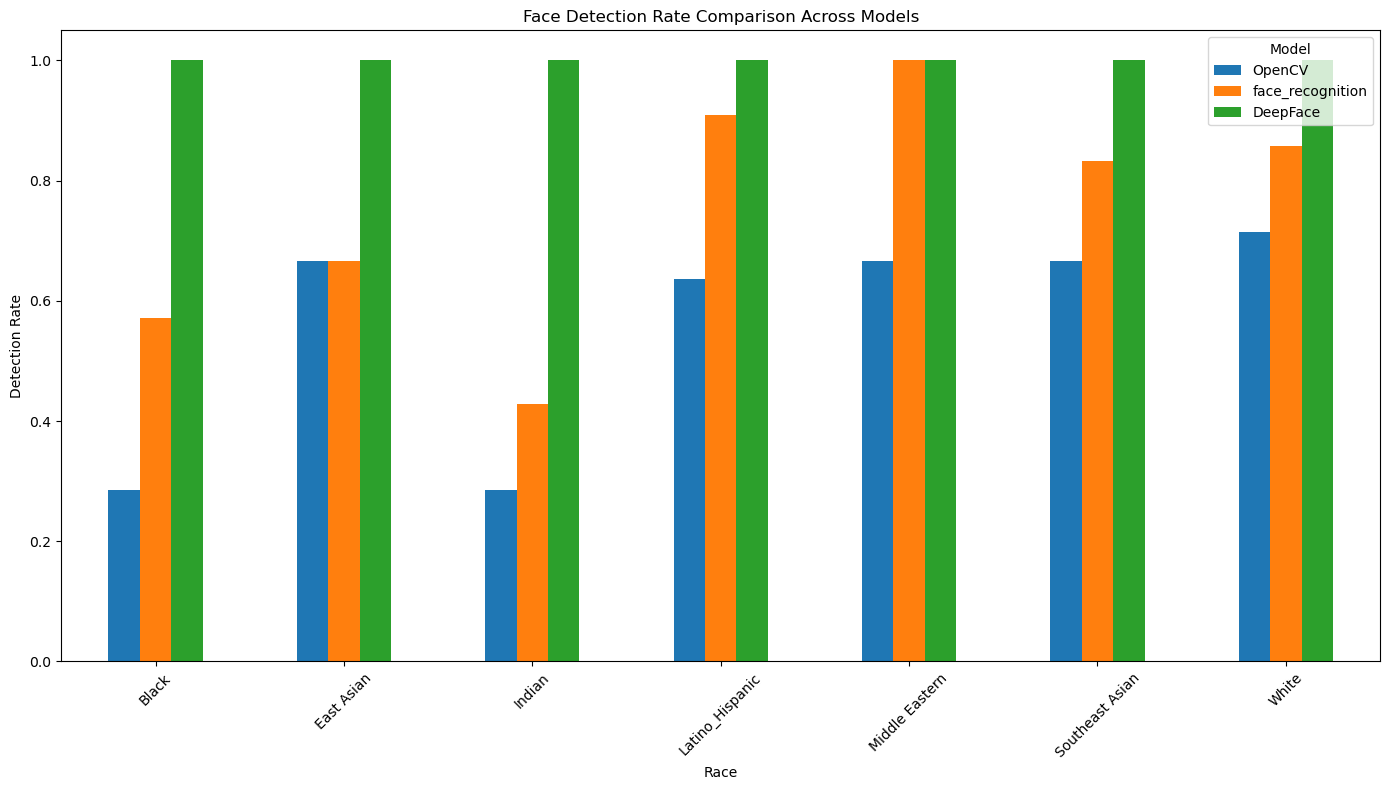

In [27]:
# Load FairFace dataset
try:
    data_df = load_fairface_data(split='train')  # Using train split as per your path configuration
    print(f"Loaded {len(data_df)} images from FairFace dataset")
    
    # Check if any image paths are invalid
    invalid_paths = []
    for idx, row in data_df.iterrows():
        if not os.path.exists(row['image_path']):
            invalid_paths.append(row['image_path'])
            
    if invalid_paths:
        print(f"Warning: Found {len(invalid_paths)} invalid image paths")
        print(f"First few invalid paths: {invalid_paths[:5]}")
        
        # Remove invalid paths from dataframe
        valid_paths_mask = data_df['image_path'].apply(os.path.exists)
        data_df = data_df[valid_paths_mask]
        print(f"Proceeding with {len(data_df)} valid images")
    
    # Display dataset statistics
    print("\nRace distribution in dataset:")
    print(data_df['race'].value_counts())
    
    # Set sample size for faster testing
    # For the full analysis, set sample_size=None
    sample_size = 50  # Reduced for initial testing; set to None for full analysis
    
    # Run analyses
    opencv_results = analyze_opencv_haar(data_df, sample_size=sample_size)
    analyze_opencv_results(opencv_results)
    
    deepface_results = analyze_deepface(data_df, sample_size=sample_size)
    analyze_deepface_results(deepface_results)
    
    face_recognition_results = analyze_face_recognition(data_df, sample_size=sample_size)
    analyze_face_recognition_results(face_recognition_results)
    
    # Generate comparative analysis
    print("\n--- Comparative Analysis ---")
    
    # Compare detection rates
    opencv_detection = opencv_results.groupby('race')['detected'].mean()
    face_recognition_detection = face_recognition_results['encoding'].groupby('race')['detected'].mean()
    
    # Create combined dataframe for comparison
    comparison_df = pd.DataFrame({
        'OpenCV': opencv_detection,
        'face_recognition': face_recognition_detection
    })
    
    # Add DeepFace detection rate if available (based on successful analysis)
    if 'race_classification' in deepface_results and len(deepface_results['race_classification']) > 0:
        deepface_detection = deepface_results['race_classification'].groupby('actual_race').apply(
            lambda x: (~x['predicted_race'].isna()).mean()
        )
        comparison_df['DeepFace'] = deepface_detection
    
    print("\nDetection Rate Comparison:")
    print(comparison_df)
    
    # Plot comparative detection rates
    plt.figure(figsize=(14, 8))
    comparison_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Face Detection Rate Comparison Across Models')
    plt.xlabel('Race')
    plt.ylabel('Detection Rate')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'comparative_detection_rates.png'))
    
    print("\nAnalysis complete. Results saved to:", RESULTS_PATH)
    
except Exception as e:
    print(f"Error in main analysis: {e}")
    import traceback
    traceback.print_exc()